In [4]:
import os, tempfile
import logging
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

In [6]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [7]:
from experiments.ical_li import (li_act_and_tau,
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

In [8]:
modelfile = 'models/courtemanche_ical.mmt'

## Plot steady-state and tau functions

In [9]:
from ionchannelABC.visualization import plot_variables

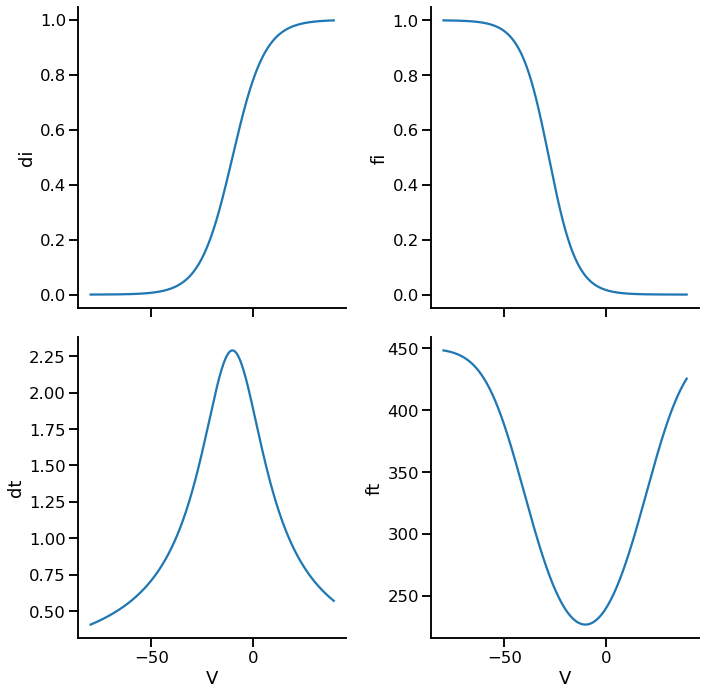

In [11]:
sns.set_context('talk')

V = np.arange(-80, 40, 0.01)

cou_vars = {'di': 'ical.d_inf',
            'fi': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'ft': 'ical.tau_f'}

f, ax = plot_variables(V, cou_vars, 'models/courtemanche_ical.mmt', figshape=(2,2))

## d gate -> Only activation data

In [34]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                 li_inact_kin_80,
                                                 li_recov)

In [35]:
assert len(observations)==len(summary_statistics(model({})))

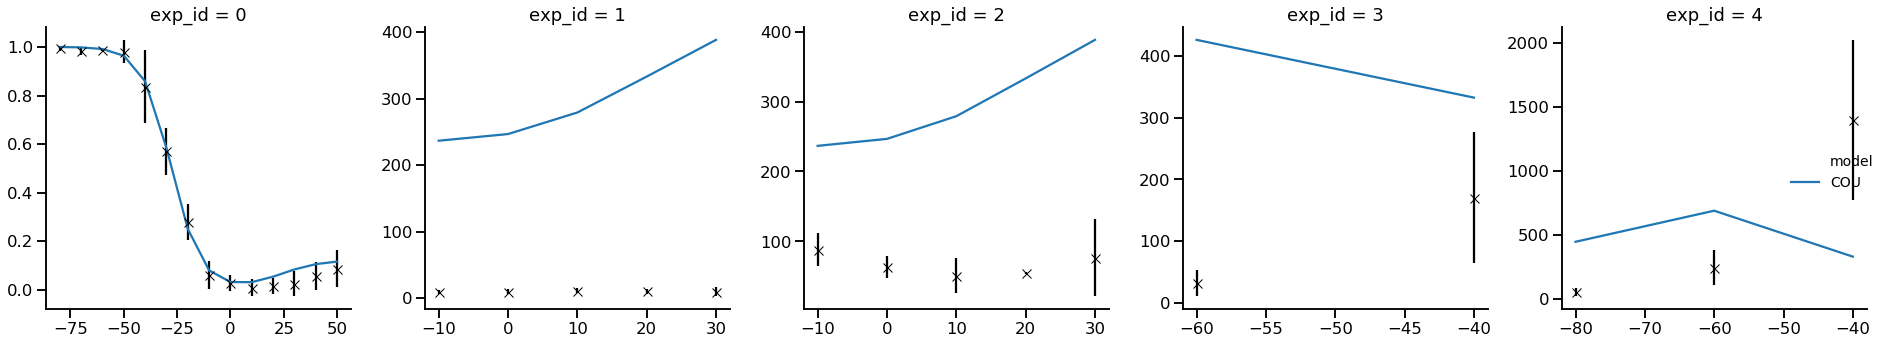

In [36]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov)

In [37]:
limits = {'log_ical.q1': (0, 3),
          'log_ical.q2': (-2, 3),
          'log_ical.q3': (-4, 0),
          'ical.q4': (-100, 100),
          'log_ical.q5': (-4, 0),
          'ical.q6': (-100, 100),
          'ical.q7': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [39]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_ical_fgate_full.db"))

In [40]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [41]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [42]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9837148289810969, '1': 0.9837148289810969, '2': 0.9837148289810969, '3': 0.9837148289810969, '4': 0.32559180605160337, '5': 0.5055241199222263, '6': 0.6753486289586008, '7': 0.8392681990941823, '8': 0.9837148289810969, '9': 0.9837148289810969, '10': 0.9837148289810969, '11': 0.9196236649649017, '12': 0.8392681990941823, '13': 0.630982660632852, '14': 0.4608478344438249, '15': 0.41845619672000584, '16': 0.3688677609080382, '17': 0.4191992497796025, '18': 0.21952975590454926, '19': 0.5102122707484876, '20': 0.7659862673065289, '21': 0.4791367008919786, '22': 2.7544015211470714, '23': 0.21885528270246787, '24': 2.7490646934055034, '25': 0.5560031468540616, '26': 4.590669201911785, '27': 2.3543059353664946, '28': 0.5128531003233775}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [43]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [44]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-18 13:00:18.672140, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 13529
DEBUG:Epsilon:new eps, t=1, eps=12.23621431947022
INFO:ABC:t:1 eps:12.23621431947022
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 18820
DEBUG:Epsilon:new eps, t=2, eps=2.722928347980856
INFO:ABC:t:2 eps:2.722928347980856
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 24203
DEBUG:Epsilon:new eps, t=3, eps=2.142896999846905
INFO:ABC:t:3 eps:2.142896999846905
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 30496
DEBUG:Epsilon:new eps, t=4, eps=1.9438174194207405
INFO:ABC:t:4 eps:1.9438174194207405
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 37582
DEBUG:Epsilon:new eps, t=5, eps=1.8399611386008

In [23]:
history = History(db_path)

In [24]:
df, w = history.get_distribution(m=0)

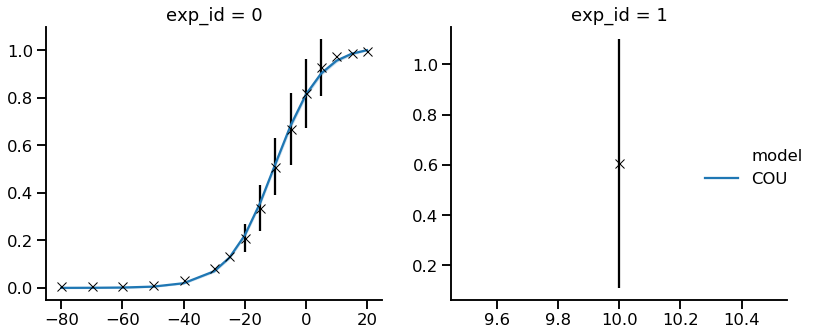

In [25]:
g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     df=df, w=w)

In [26]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [27]:
m,_,_ = myokit.load(modelfile)

In [28]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

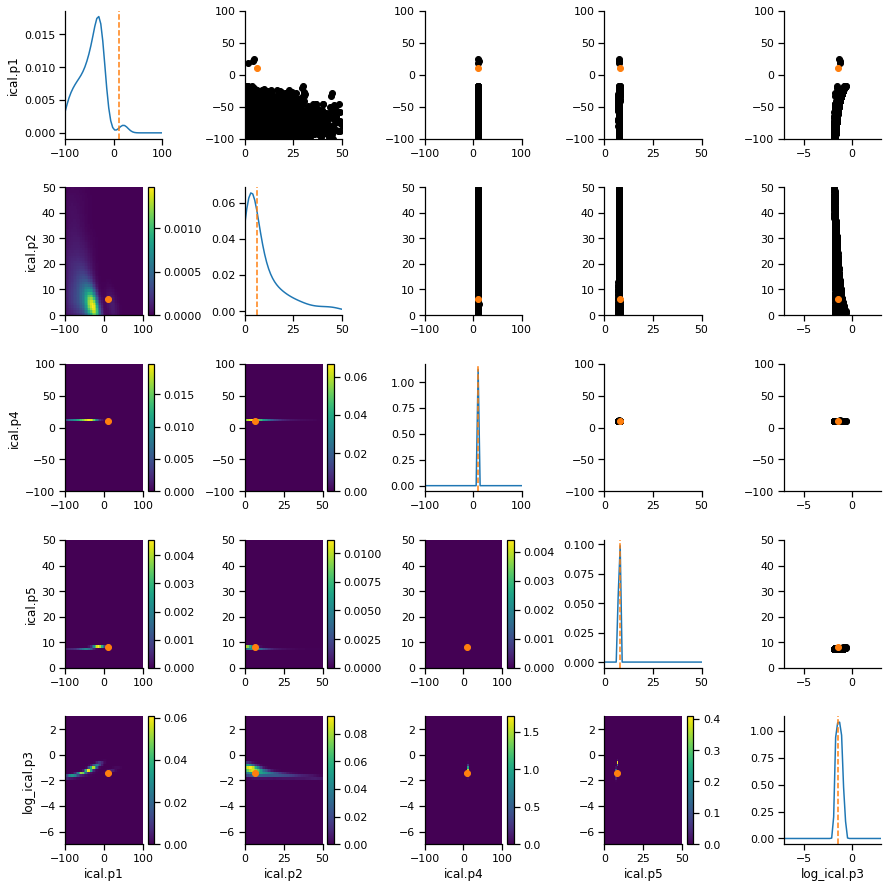

In [29]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

In [30]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

In [31]:
from ionchannelABC.visualization import plot_variables

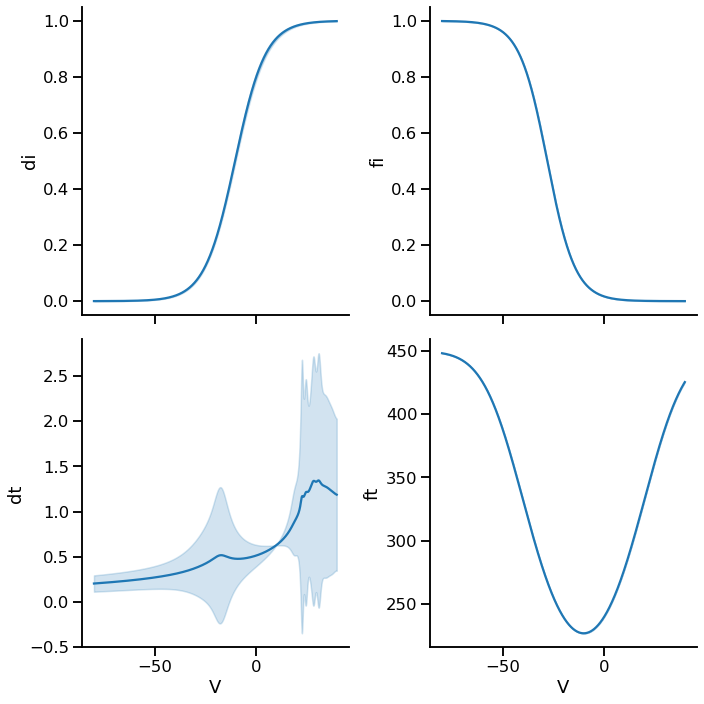

In [33]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
V = np.arange(-80, 40, 0.01)

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_ical.mmt', 
                       [cou_pars],
                       figshape=(2,2))

## f gate -> Only inactivation data

In [12]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau)

In [13]:
assert len(observations)==len(summary_statistics(model({})))

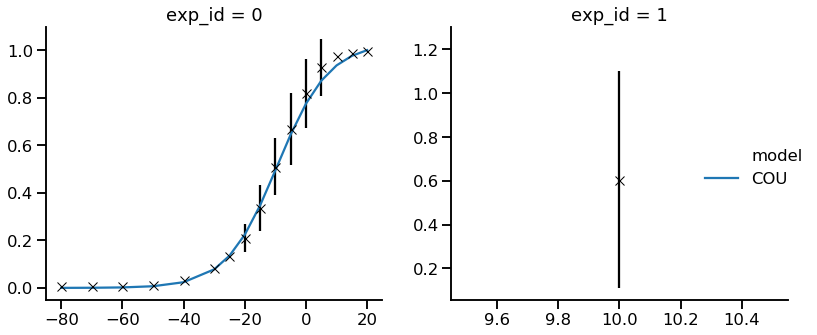

In [14]:
g = plot_sim_results(modelfile,
                     li_act_and_tau)

In [15]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [16]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_ical_dgate_full.db"))

In [17]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [18]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32 particles


In [19]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2287454676498424, '1': 1.2287454676498424, '2': 1.2287454676498424, '3': 1.2287454676498424, '4': 1.2287454676498424, '5': 1.2287454676498424, '6': 1.2287454676498424, '7': 1.0293830767146164, '8': 0.6283247351374927, '9': 0.5133263088125923, '10': 0.4040167399213943, '11': 0.41888315675832816, '12': 0.5146915383573082, '13': 1.2287454676498424, '14': 1.2287454676498424, '15': 1.2287454676498424, '16': 1.2039197677998432}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [20]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [21]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-18 11:23:07.136757, end_time=None)>


In [22]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2718
DEBUG:Epsilon:new eps, t=1, eps=2.3341083502077473
INFO:ABC:t:1 eps:2.3341083502077473
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 6798
DEBUG:Epsilon:new eps, t=2, eps=1.4388485321914328
INFO:ABC:t:2 eps:1.4388485321914328
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 11092
DEBUG:Epsilon:new eps, t=3, eps=1.292902313705072
INFO:ABC:t:3 eps:1.292902313705072
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 16188
DEBUG:Epsilon:new eps, t=4, eps=1.1751087332605836
INFO:ABC:t:4 eps:1.1751087332605836
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 21841
DEBUG:Epsilon:new eps, t=5, eps=0.95105544870

In [23]:
history = History(db_path)

In [24]:
df, w = history.get_distribution(m=0)

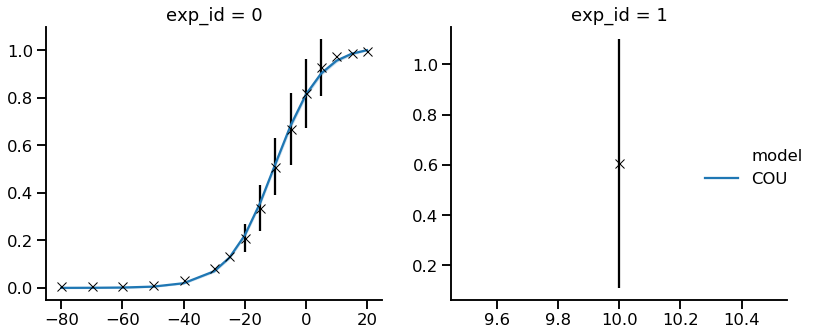

In [25]:
g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     df=df, w=w)

In [26]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [27]:
m,_,_ = myokit.load(modelfile)

In [28]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

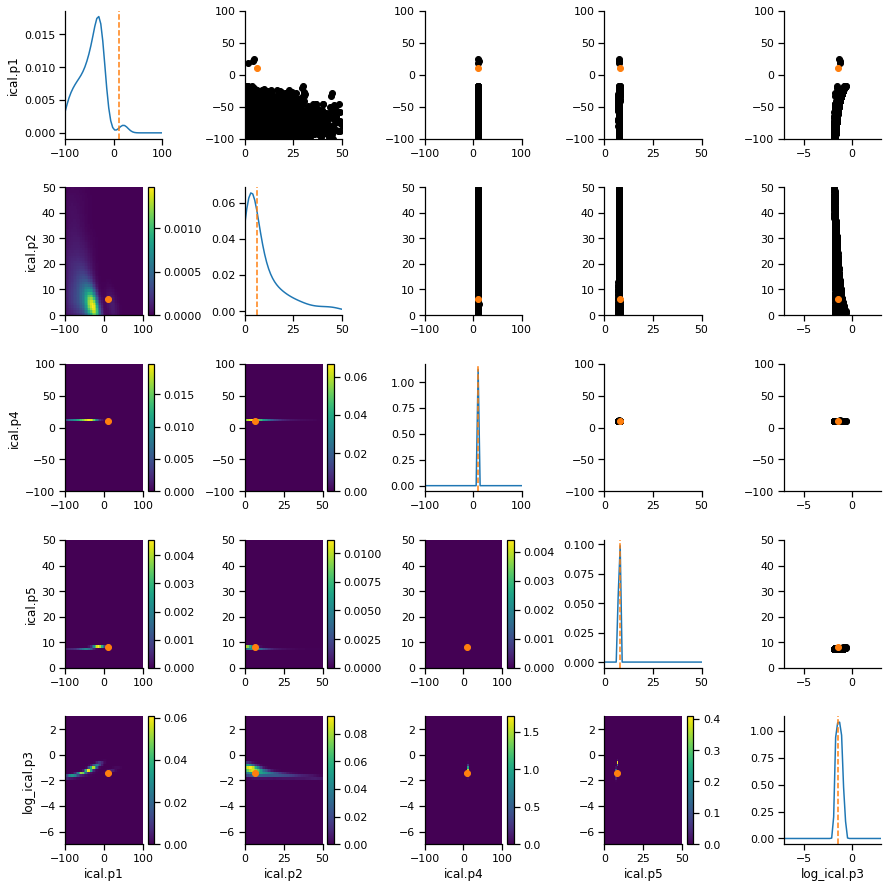

In [29]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

In [30]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

In [31]:
from ionchannelABC.visualization import plot_variables

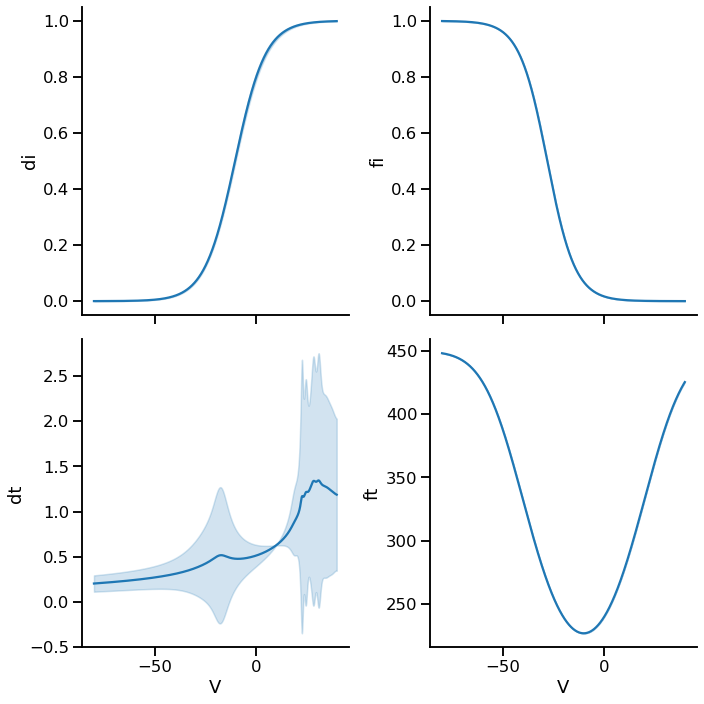

In [33]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
V = np.arange(-80, 40, 0.01)

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_ical.mmt', 
                       [cou_pars],
                       figshape=(2,2))

## obsolete | Full calibration

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau,
                                                li_inact_1000,
                                                li_inact_kin_taus_80,
                                                li_recov_taus)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

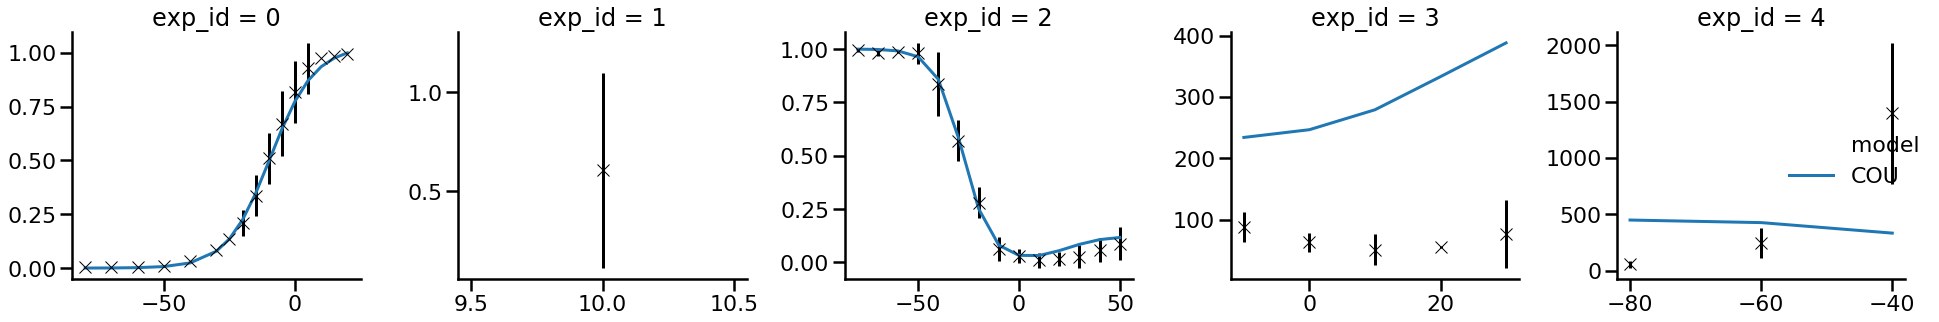

In [10]:
g = plot_sim_results(modelfile,
                     li_act_and_tau,
                    li_inact_1000,
                    li_inact_kin_taus_80,
                    li_recov_taus)

In [12]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (0, 100),
          'ical.p5': (0, 50),
          'log_ical.q1': (0, 3),
          'log_ical.q2': (-2, 3),
          'log_ical.q3': (-4, 0),
          'ical.q4': (-100, 100),
          'log_ical.q5': (-4, 0),
          'ical.q6': (-100, 100),
          'ical.q7': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [13]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_ical_full.db"))

In [14]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [15]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 4096 particles


In [16]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9398752239292515, '1': 0.9398752239292515, '2': 0.9398752239292515, '3': 0.9398752239292515, '4': 0.9398752239292515, '5': 0.9398752239292515, '6': 0.9398752239292515, '7': 0.7873816630116267, '8': 0.48060958651359004, '9': 0.39264655874319737, '10': 0.30903497420915627, '11': 0.3204063910090598, '12': 0.39369083150581335, '13': 0.9398752239292515, '14': 0.9398752239292515, '15': 0.9398752239292515, '16': 0.9208858882042976, '17': 1.0741431130620016, '18': 1.0741431130620016, '19': 1.0741431130620016, '20': 1.0741431130620016, '21': 0.3555219315967729, '22': 0.5519945780055159, '23': 0.7374302565542455, '24': 0.9164181829023621, '25': 1.0741431130620016, '26': 1.0741431130620016, '27': 1.0741431130620016, '28': 1.0041603493504605, '29': 0.9164181829023621, '30': 0.6889859331309726, '31': 0.5571136885187125, '32': 0.8363997873037939, '33': 0.523181487475835, '34': 3.007600716573605, '35': 0.23897362095840746, '36': 5.012667860956007, '37': 2.570726

In [17]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [18]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-12 14:47:01.690069, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 16638
DEBUG:Epsilon:new eps, t=1, eps=6.814108502862785
INFO:ABC:t:1 eps:6.814108502862785
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 22826
DEBUG:Epsilon:new eps, t=2, eps=2.946901690888519
INFO:ABC:t:2 eps:2.946901690888519
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 28978
DEBUG:Epsilon:new eps, t=3, eps=2.4943004196225407
INFO:ABC:t:3 eps:2.4943004196225407
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 36917
DEBUG:Epsilon:new eps, t=4, eps=2.1399641793343487
INFO:ABC:t:4 eps:2.1399641793343487
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 47713
DEBUG:Epsilon:new eps, t=5, eps=1.90086945688

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

In [21]:
history = History(db_path)

In [22]:
df, w = history.get_distribution(m=0)

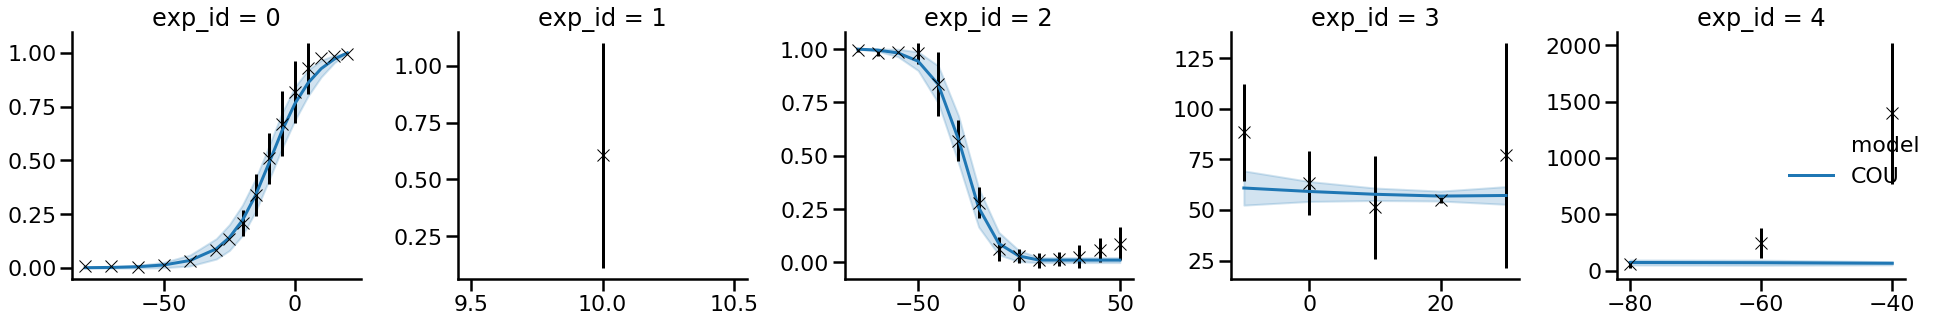

In [24]:
g = plot_sim_results(modelfile,
                     li_act_and_tau,
                    li_inact_1000,
                    li_inact_kin_taus_80,
                    li_recov_taus,
                     df=df, w=w)

In [25]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [26]:
m,_,_ = myokit.load(modelfile)

In [27]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

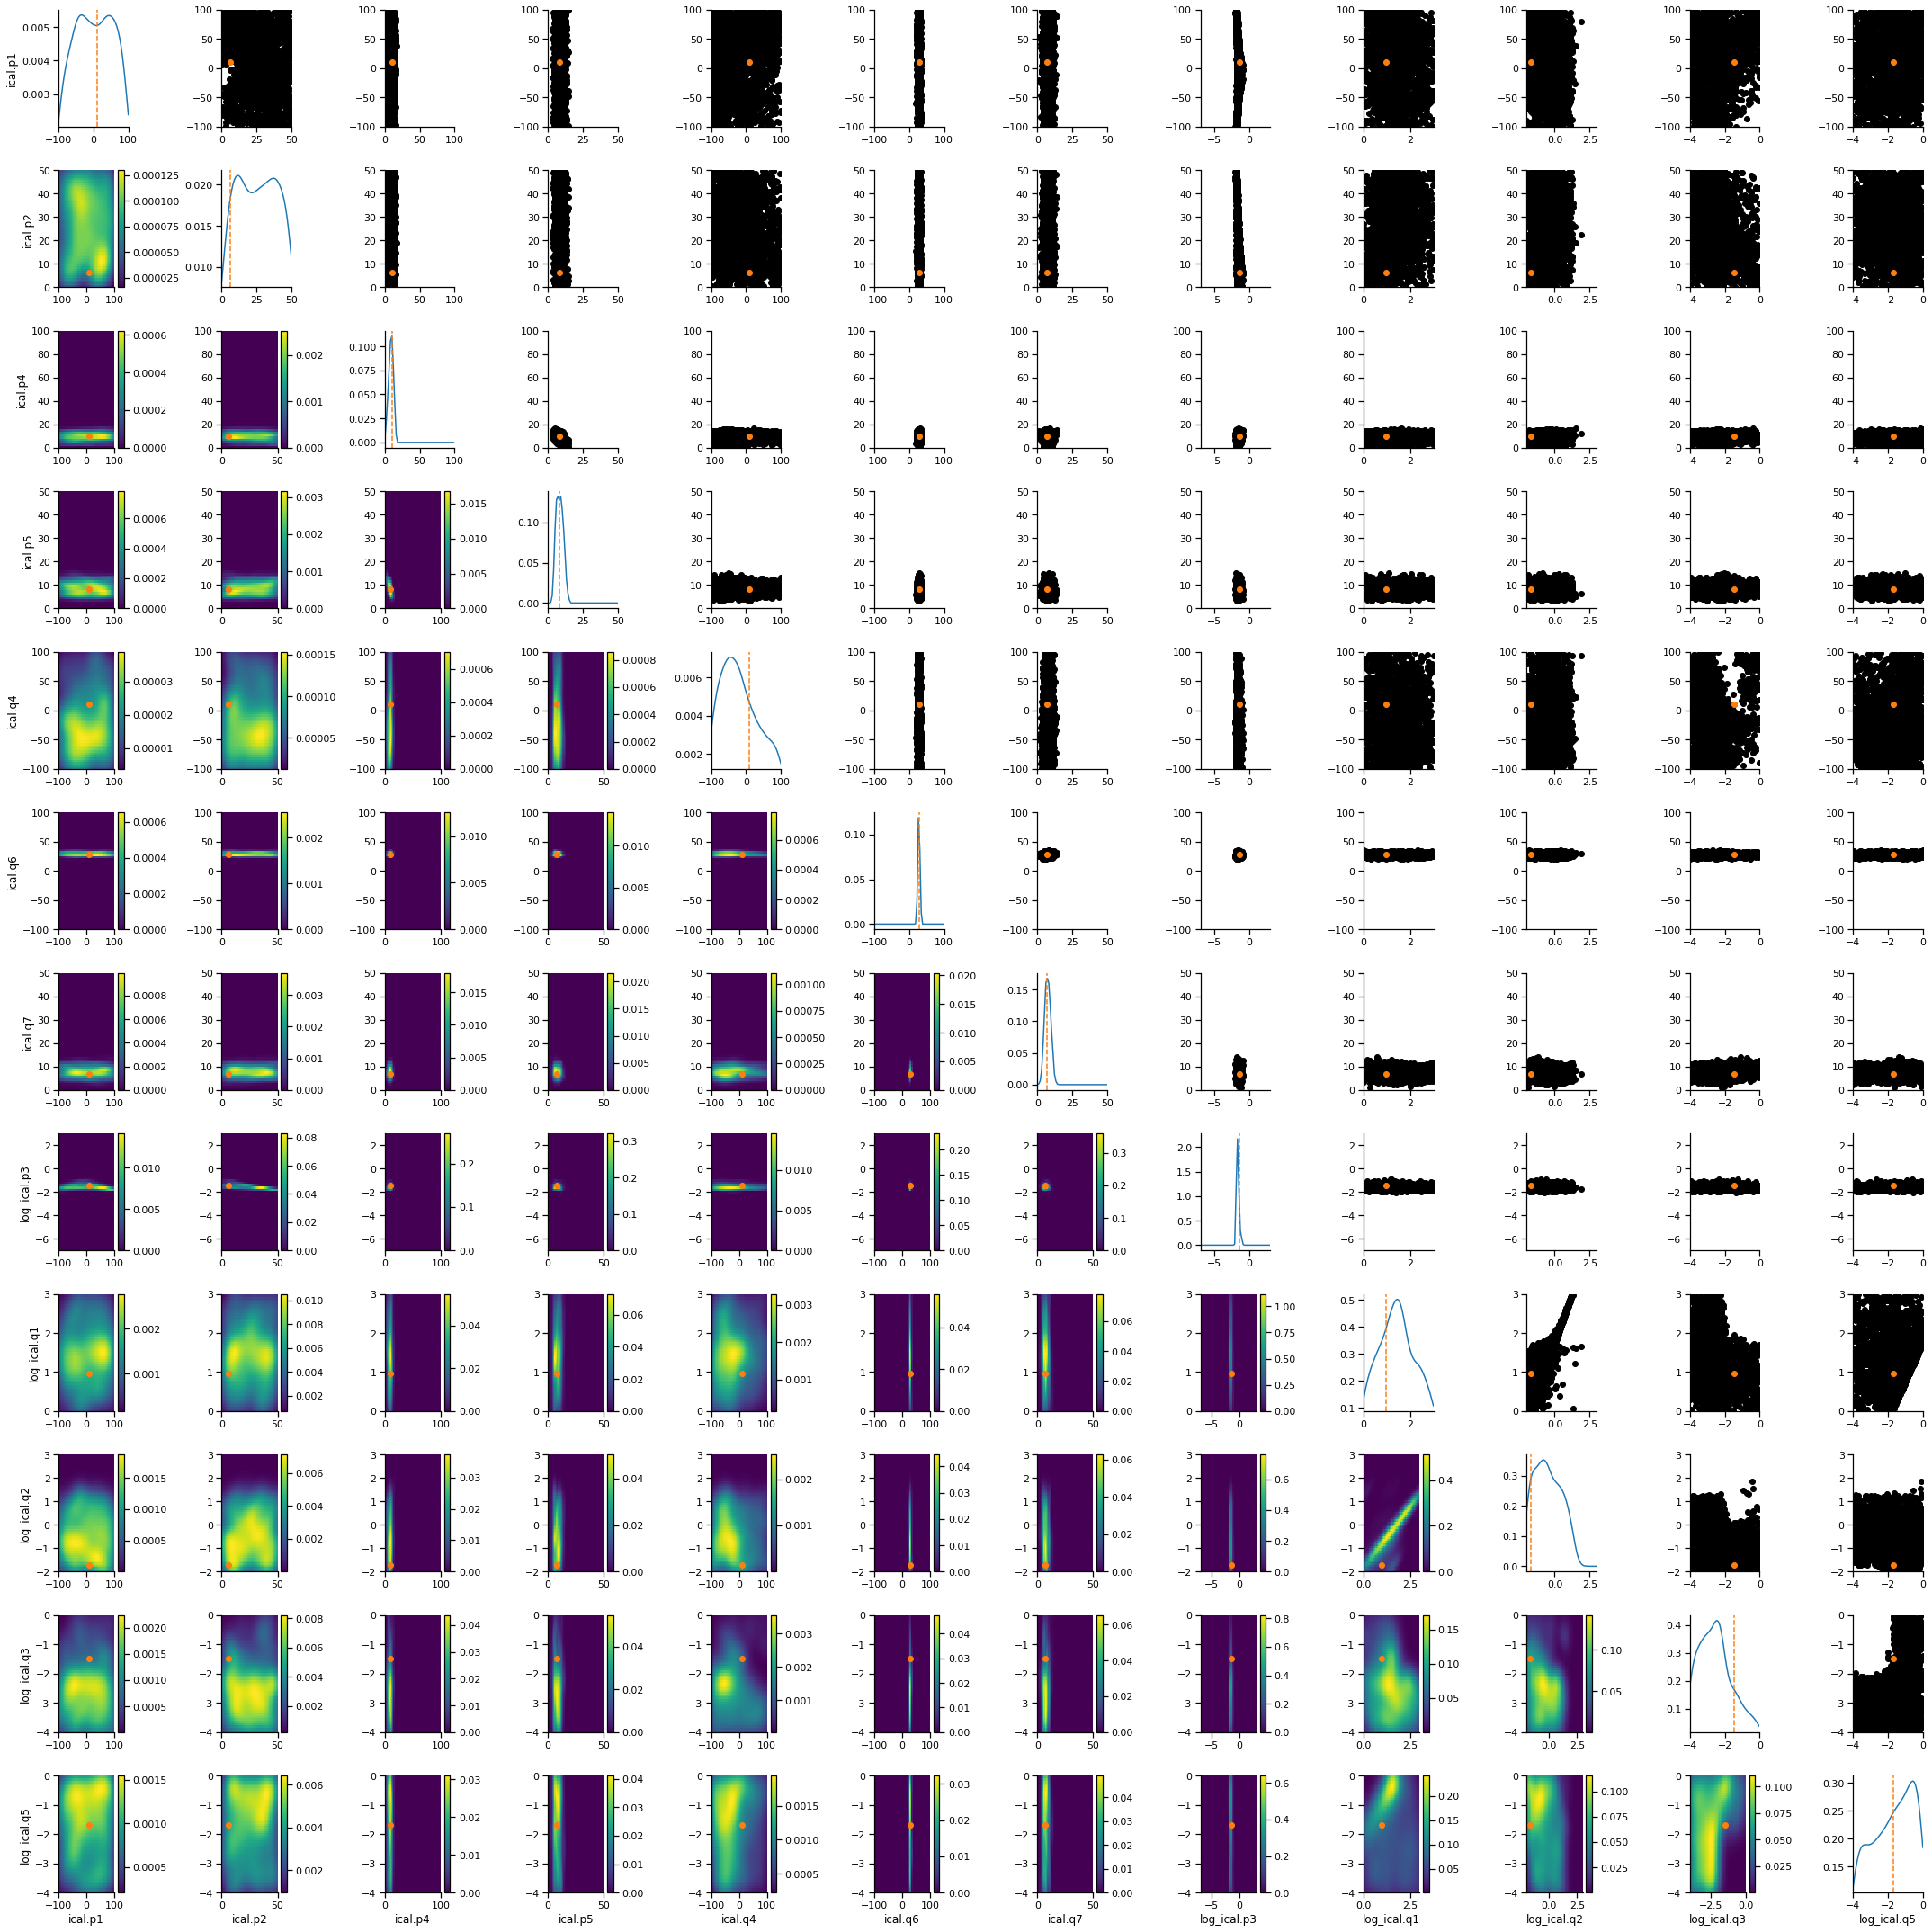

In [28]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

In [29]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

In [30]:
from ionchannelABC.visualization import plot_variables

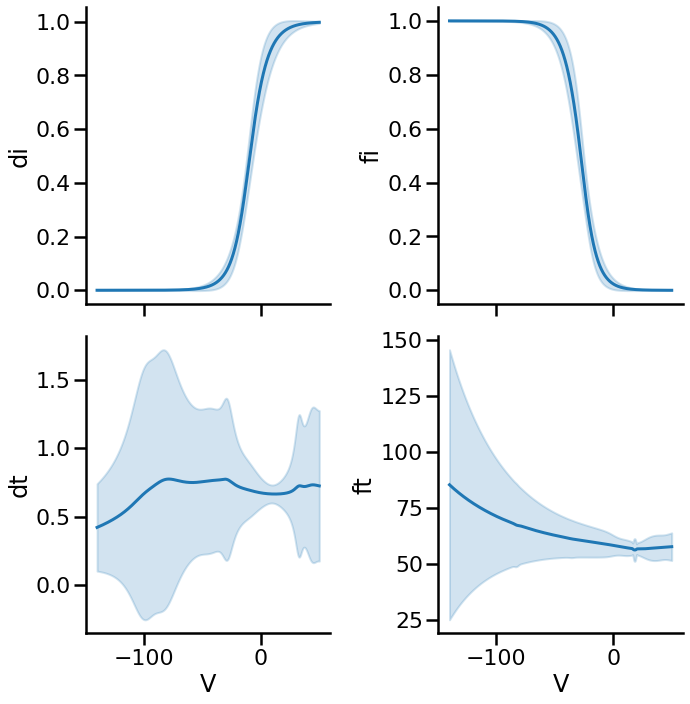

In [31]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
V = np.arange(-140, 50, 0.01)

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_ical.mmt', 
                       [cou_pars],
                       figshape=(2,2))